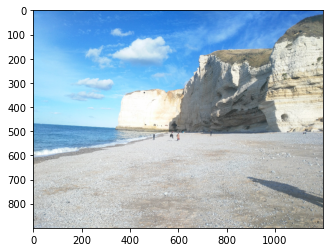

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.io import imread,imshow,imsave
%matplotlib inline

im = imread('etretat.jpg')
plt.figure()
plt.imshow(im)
plt.show()

uint8


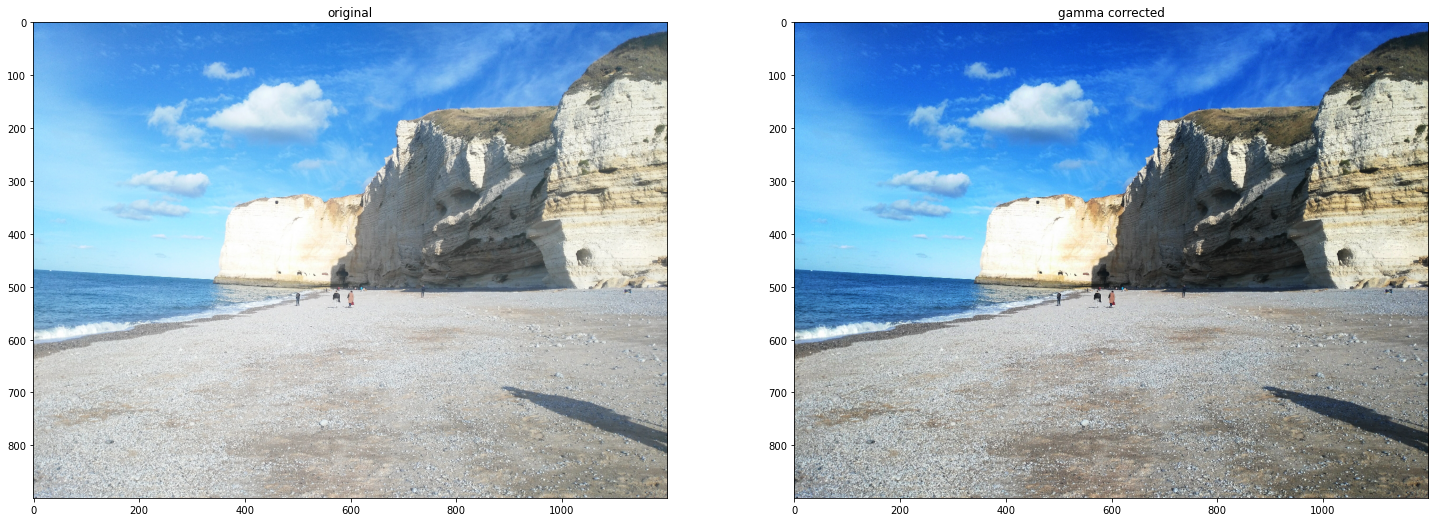

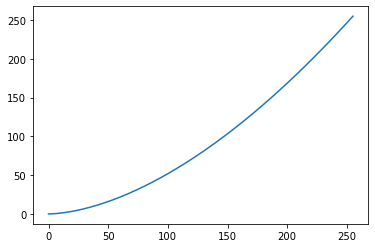

In [10]:
#gamma correction


gamma = 1.7  #Choice of the gamma value 
lut_gam = np.power(np.arange(0,256),gamma) * np.power(255,1-gamma)

print(im.dtype)
im_gam = lut_gam[im].astype('uint8') #Casting necessary to be in the good range of values 
                                     #((0:255) if int, (0:1) if float) for imshow()
                                     

plt.figure(figsize=(25,25))
plt.subplot(1,2,1)
plt.title('original')
plt.imshow(im)
plt.subplot(1,2,2)
plt.title('gamma corrected')
plt.imshow(im_gam)
plt.show()

plt.figure()
plt.plot(lut_gam)
plt.show()

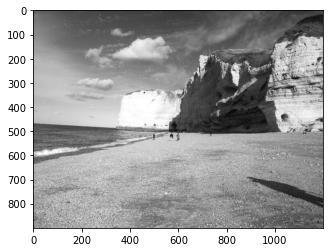

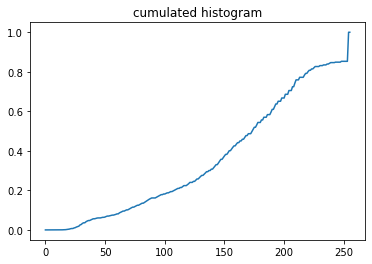

In [11]:
#rgb->gray => cumulated histogram
from skimage.color import rgb2gray
imgray = (rgb2gray(im_gam)*255)#.astype('uint8')
plt.figure()
plt.imshow(imgray, cmap= plt.cm.gray)
plt.show()

def cumul_hist(imgray):
    cumul_hist= np.zeros((256,))
    c=0
    for v in range(256):
        c+= (imgray==v).sum()
        cumul_hist[v] = c
    cumul_hist /= cumul_hist.max() #val btween 0 and 1 (=proba)
    return cumul_hist

h = cumul_hist(imgray)

plt.figure()
plt.plot(h)
plt.title('cumulated histogram')
plt.show()

28 254


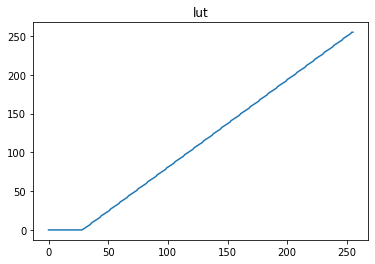

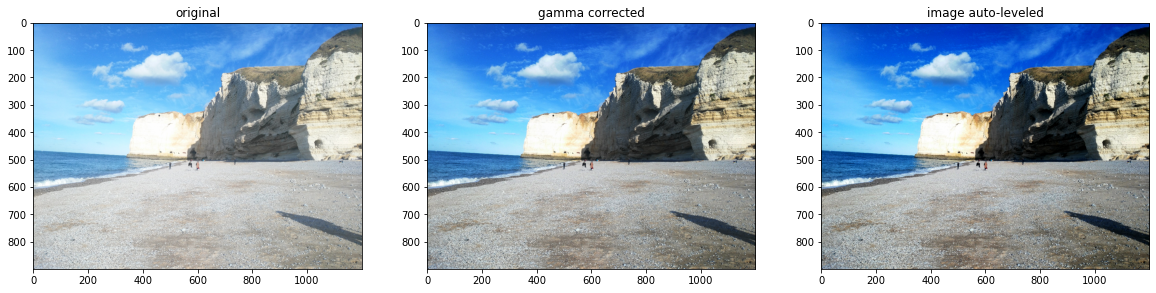

In [12]:
for v in range(256):
    if h[v] > 0.02:   #separates the darkest and less frequent pixels
        break
Tmin = v-1
if(v==0):
    Tmin = 0
    
for n in range(256):  #separates the clearest and less frequent pixels
    if h[255-n] < 0.98:
        break
Tmax = (255-n)+1
if (n==0):
    Tmax = 255
print(Tmin, Tmax)

lut = np.arange(256)  #look up table for the auto-level
lut[:Tmin]=0       #assign the darkest pixels to 0
lut[Tmax:]=255     #assign the clearest pixels to 255
lut[Tmin:Tmax]= (255/(Tmax-Tmin))*(lut[Tmin:Tmax]-Tmin)  #linear evolution for the 
                                                         #frequent pixels values
plt.figure()
plt.plot(lut)
plt.title('lut')
plt.show()

im_lut = lut[im_gam]  #auto level

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.title('original')
plt.imshow(im)
plt.subplot(1,3,2)
plt.imshow(im_gam)
plt.title('gamma corrected')
plt.subplot(1,3,3)
plt.imshow(im_lut)
plt.title('image auto-leveled')
plt.show()

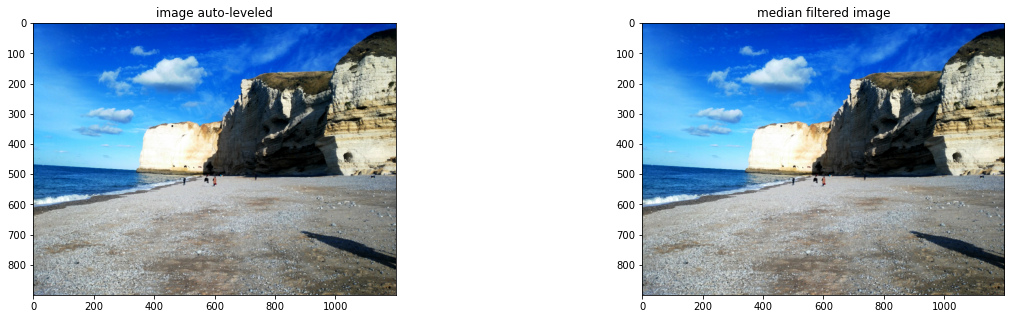

In [22]:
#noise reduction

from skimage.filters import median #based on the labo2, we chose the median filter
                                   #instead of the mean filter 
                                   #to have better results (less blured)
from skimage.morphology import disk



for i in range(im_filtered.shape[2]): #im.shape[2] => 3 channels = RGB
    im_filtered[:,:,i] = median(im_lut[:,:,i], disk(1)) #going through all channels
    

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.imshow(im_lut)
plt.title('image auto-leveled')
plt.subplot(1,2,2)
plt.imshow(im_filtered)
plt.title('median filtered image')
plt.show()

float64


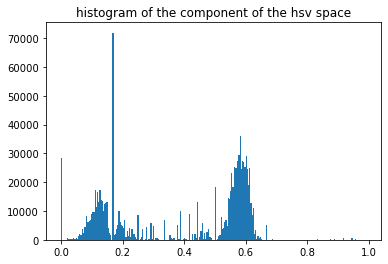

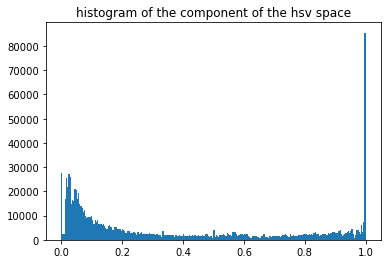

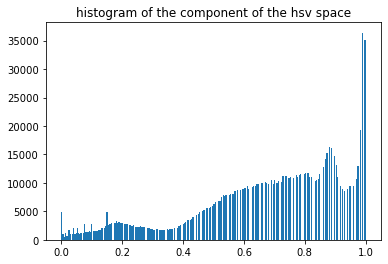

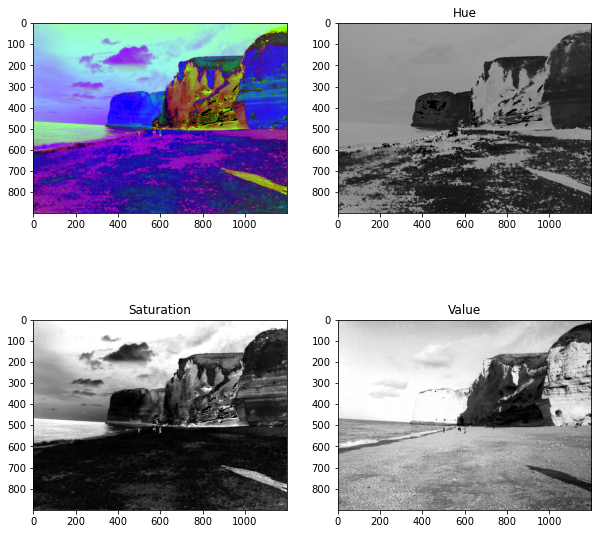

In [26]:
#to increase the color saturation, conversion in hsv space and analysis


from skimage.color import rgb2hsv, hsv2rgb
im_hsv = rgb2hsv(im_filtered.astype('uint8')) #Casting necessary to be in the good range 
                                              #for hsv2rgb method
print(im_hsv.dtype)

for i in range(im_hsv.shape[2]):
    plt.figure()
    plt.title('histogram of the component of the hsv space')
    plt.hist(im_hsv[:,:,i].flatten(), bins=256)
    plt.show()
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(im_hsv)
plt.subplot(2,2,2)
plt.imshow(im_hsv[:,:,0],cmap=plt.cm.gray)
plt.title('Hue')
plt.subplot(2,2,3)
plt.imshow(im_hsv[:,:,1],cmap=plt.cm.gray)
plt.title('Saturation')
plt.subplot(2,2,4)
plt.imshow(im_hsv[:,:,2],cmap=plt.cm.gray)
plt.title('Value')
plt.show()

float64


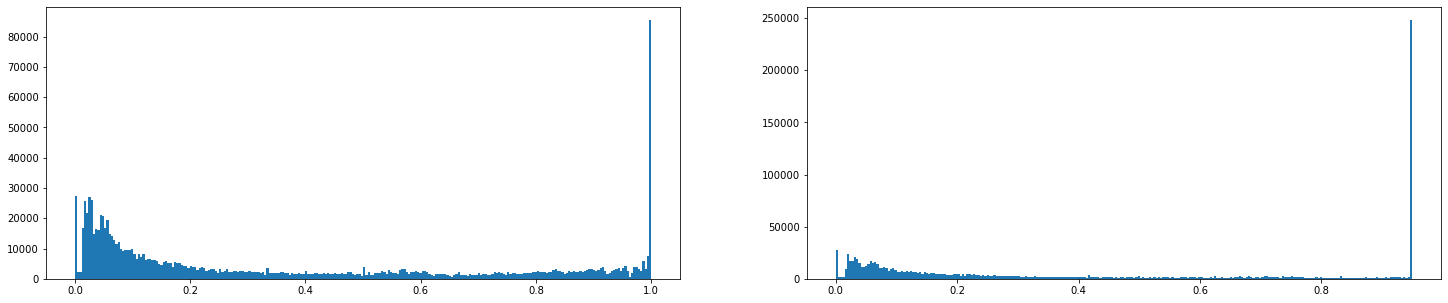

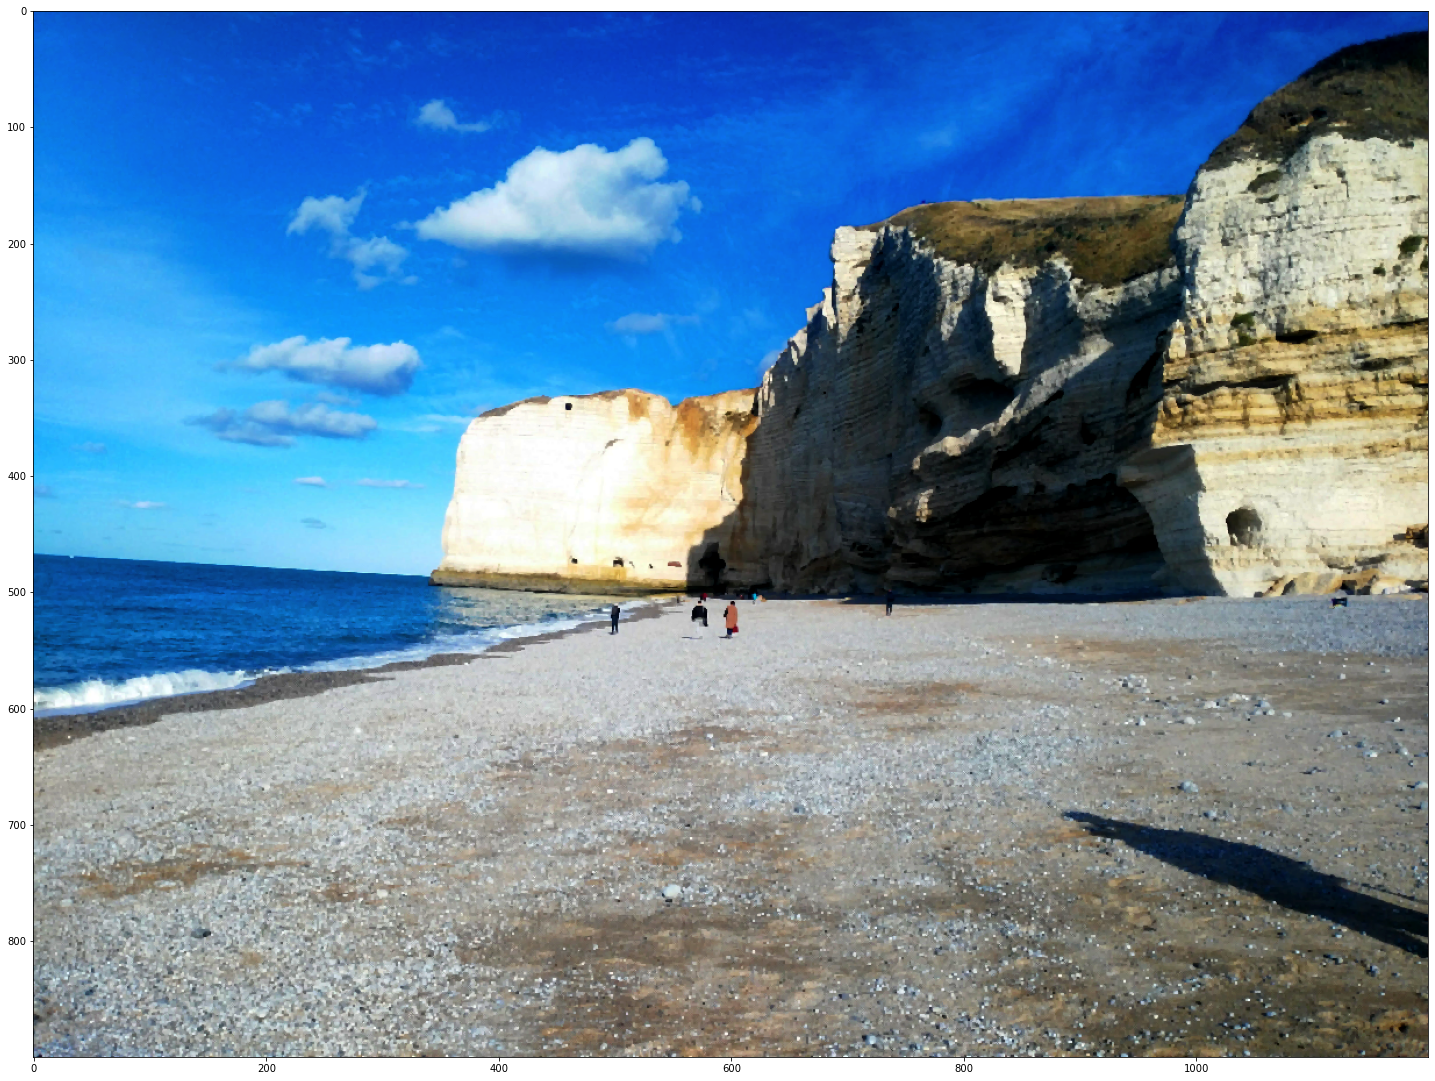

In [27]:
#Increasing saturation of HSV image
im_sat=im_hsv.copy()
im_sat[:,:,1]*=1.25
mask_sat=im_sat[:,:,1]>0.95
im_sat[:,:,1][mask_sat==True]=0.95

print(im_sat.dtype)
#plotting saturation of the image before/after increase
plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
plt.hist(im_hsv[:,:,1].flatten(), bins=256)
plt.subplot(1,2,2)
plt.hist(im_sat[:,:,1].flatten(), bins=256)
plt.show()

#Back to RGB image to see the contrast increase due to Saturation increase
plt.figure(figsize=(25,25))
plt.imshow(hsv2rgb(im_sat))
plt.show()

float64


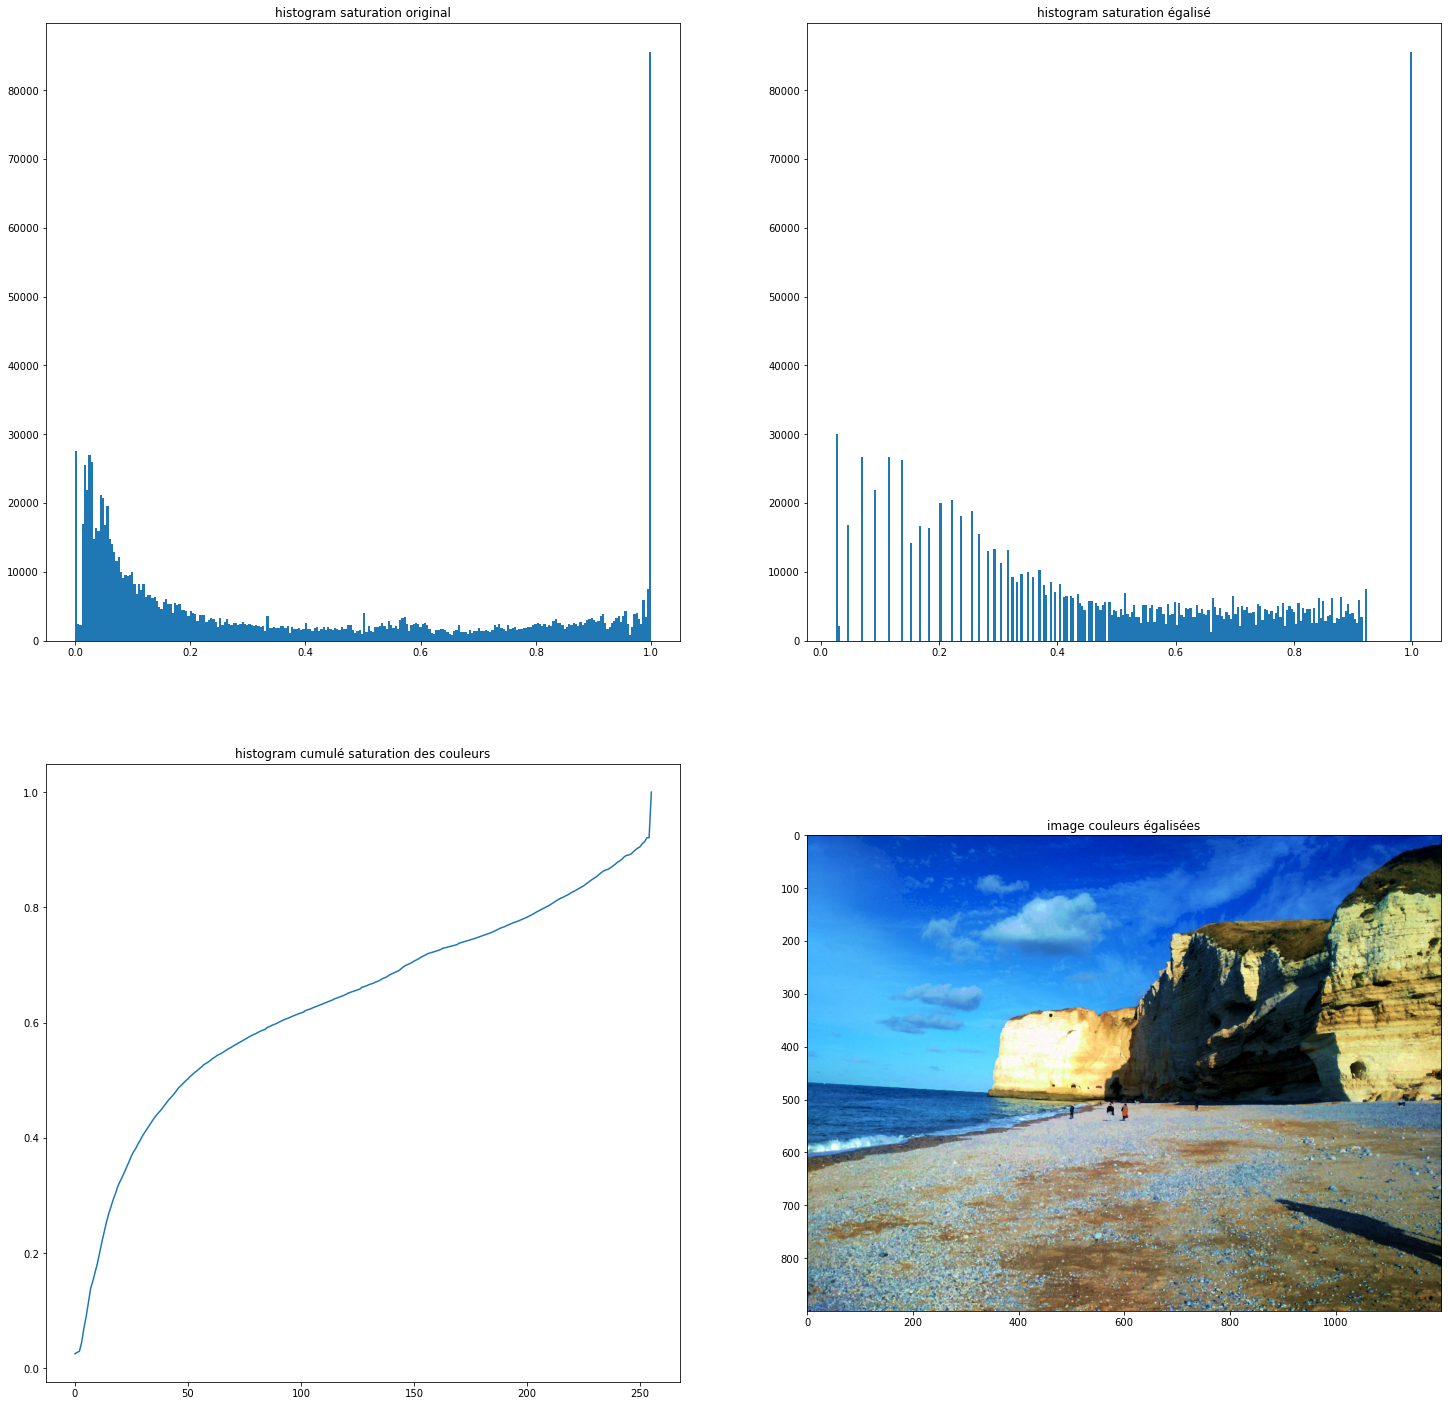

In [29]:
#comparison with another idea : equalization of the saturation histogram

h_equal = cumul_hist((im_hsv[:,:,1]*255).astype('int'))

im_equal = im_hsv.copy()
im_equal[:,:,1] = h_equal[(255*im_hsv[:,:,1]).astype('uint8')]

#could also use a local equalization : 

#skr.equalize((im_equal[:,:,1]*255).astype('uint8'), disk(10))
#im_equal[:,:,1]/=255

print(im_equal.dtype)


plt.figure(figsize=(25,25))
plt.subplot(2,2,1)
plt.title('histogram saturation original')
plt.hist(im_hsv[:,:,1].flatten(), bins=256)
plt.subplot(2,2,2)
plt.title('histogram saturation égalisé')
plt.hist(im_equal[:,:,1].flatten(), bins=256)
plt.subplot(2,2,3)
plt.title('histogram cumulé saturation des couleurs')
plt.plot(h_equal)
plt.subplot(2,2,4)
plt.title('image couleurs égalisées')
plt.imshow(hsv2rgb(im_equal))

plt.show()

#anyway these methods do not give good results for this application 

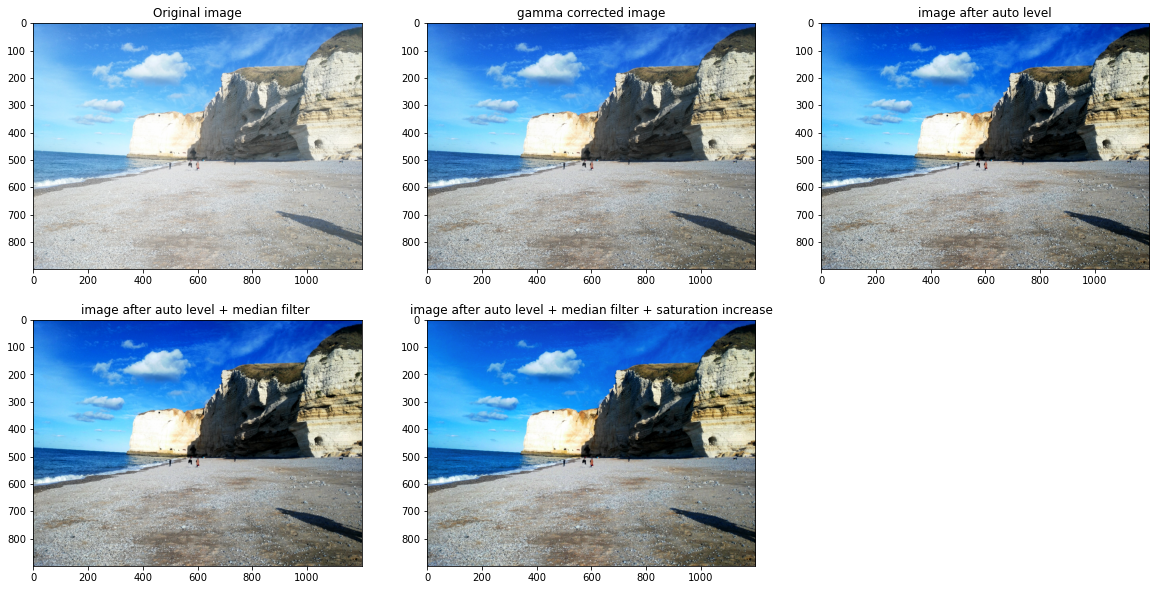

In [19]:
#compare all the different contrast-increasing methods :
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.imshow(im)
plt.title('Original image')
plt.subplot(2,3,2)
plt.title('gamma corrected image')
plt.imshow(im_gam)
plt.subplot(2,3,3)
plt.imshow(im_lut)
plt.title('image after auto level')
plt.subplot(2,3,4)
plt.imshow(im_filtered)
plt.title('image after auto level + median filter ')
plt.subplot(2,3,5)
plt.imshow(hsv2rgb(im_sat))
plt.title('image after auto level + median filter + saturation increase')
plt.show()